# Chap 1: Experiment 2

## Training a NN with _no_ hidden layer

This notebook trains a NN with _no_ hidden layer and outputs some metrics such as the train and validation set accuracies.

In [1]:
# Setup logging
import logging
from digit_classifier import base, DigitClassifier, DEVICE, Metrics, DigitClassifierConfig
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.animation as ani
import seaborn as sns
import numpy as np
from pathlib import Path
import pickle
sns.set_theme()

[digit_classifier] [INFO] Added console handler
[digit_classifier] [INFO] Torch device: cpu


In [2]:
base() # Set seeds

In [3]:
# Model parameters
config = DigitClassifierConfig(
	sizes=[784, 10],
	learning_rate=1,
  device=DEVICE,
  loss = nn.MSELoss(reduction='mean'),
  mini_batch = 10,
)

model_dir = Path("../resources/model/chap1/no_hidden_layer_mse/")
metrics_dir = model_dir / 'metrics.pkl'

## Train model

Note: this section can be skipped if model has already been trained

In [8]:
# Instantiate model for training
model = DigitClassifier(config)
model

[digit_classifier] [INFO] Train size: 60000
[digit_classifier] [INFO] Test size: 10000
[digit_classifier] [INFO] Train set: 50000
[digit_classifier] [INFO] Valid set: 10000


DigitClassifier(
  (act_fn): Sigmoid()
  (linears): ModuleList(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
  (loss_module): MSELoss()
)

In [9]:
epochs = 10
metrics = Metrics()
model.train_loop(num_epochs=epochs, metrics=metrics)

[digit_classifier] [INFO] Epoch: 0: 8939.0 / 10000
[digit_classifier] [INFO] Epoch: 1: 9009.0 / 10000
[digit_classifier] [INFO] Epoch: 2: 9047.0 / 10000
[digit_classifier] [INFO] Epoch: 3: 9080.0 / 10000
[digit_classifier] [INFO] Epoch: 4: 9096.0 / 10000
[digit_classifier] [INFO] Epoch: 5: 9104.0 / 10000
[digit_classifier] [INFO] Epoch: 6: 9091.0 / 10000
[digit_classifier] [INFO] Epoch: 7: 9097.0 / 10000
[digit_classifier] [INFO] Epoch: 8: 9111.0 / 10000
[digit_classifier] [INFO] Epoch: 9: 9120.0 / 10000


In [12]:
# Save model
model.save_model(model_dir)

# Save metrics
with open(metrics_dir, 'wb')  as f:
  pickle.dump(metrics, f)

As expected, a NN with no hidden layer performs worse:
- Slower learning
- Maximum achieved precsision is reduced

However, it's performance is still much better than any analytical approach (excluding SVM).

## Load data from checkpoint

If model has been trained before, you can skip here

In [4]:
# Load model
model = DigitClassifier.load_model(model_dir)

# Load metrics
with open(metrics_dir, 'rb') as f:
  metrics: Metrics = pickle.load(f)

[digit_classifier] [INFO] Train size: 60000
[digit_classifier] [INFO] Test size: 10000
[digit_classifier] [INFO] Train set: 50000
[digit_classifier] [INFO] Valid set: 10000


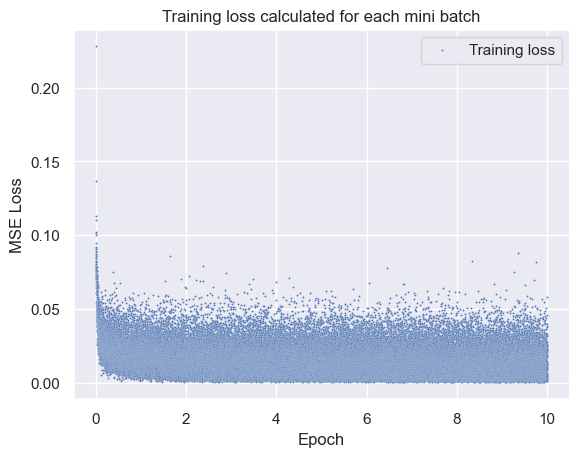

In [5]:
# Plot train loss (per batch)
x_epochs = np.arange(len(metrics.train_batch_loss)) / len(model.train_dataloader)
ax = sns.scatterplot(x=x_epochs, y=metrics.train_batch_loss, s=2, label="Training loss", legend="auto")
# sns.scatterplot(x = x_epochs, y=moving_average(train_loss_metrics, n=len(model.train_dataloader)))
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
ax.set_title("Training loss calculated for each mini batch")
plt.show()

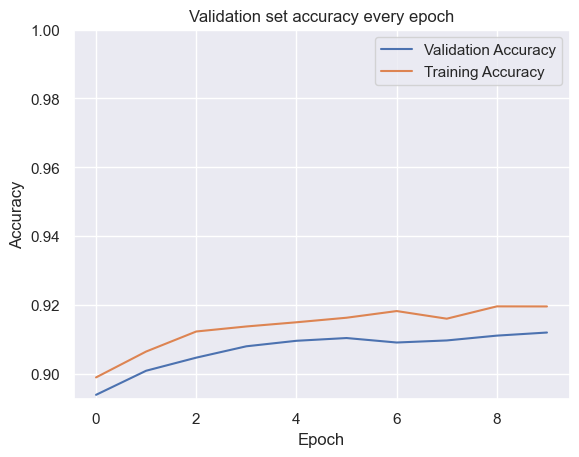

In [6]:
# Plot training and validation accuracy per epoch
ax = sns.lineplot(metrics.valid_precision_epoch,
                     label="Validation Accuracy")
sns.lineplot(metrics.train_precision_epoch, label="Training Accuracy")
ax.set_ylim(None, 1)
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("Validation set accuracy every epoch")
plt.show()

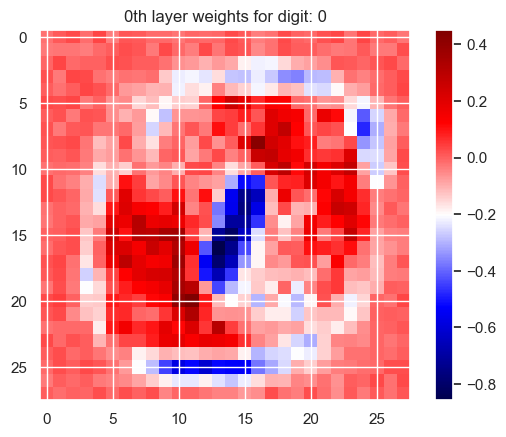

In [7]:
# Visualise the weights in the first layer
def weights(mdl: DigitClassifier, layer:int=0):
  """Return the weights in the layers 0th->layer"""
  img_size = (28,28)  
  return mdl.linears[0].weight[layer].detach().reshape(*img_size).cpu().numpy()

digit = 0

fig, ax = plt.subplots()
ax.set_title(f"0th layer weights for digit: {digit}")
im = ax.imshow(weights(model, digit), cmap=mpl.colormaps['seismic'])
fig.colorbar(im, ax=ax)

plt.show()

In [8]:
## Setup a color map renormaliser such that w=0 is in the middle
# Print out some bounds to see what works best

# Max value:
bound = abs(model.linears[0].weight.detach()).max().numpy()
print(f"Max value: {bound}")

# 3 std from the mean
bound = 3 * abs(model.linears[0].weight.detach()).std().numpy()
print(f"3 std: {bound}")

# Set bound to 0.5 (this seemed sensible)
bound = 0.5
print(f"Setting bound to: {bound}")
norm = cm.colors.Normalize(vmax=bound, vmin=-bound)

Max value: 1.9481966495513916
3 std: 0.5106891989707947
Setting bound to: 0.5


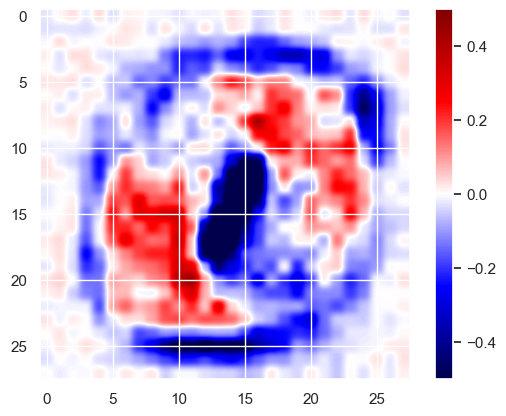

In [9]:
fig, ax = plt.subplots()
im = ax.imshow(weights(model, 0),
               cmap=mpl.colormaps['seismic'], norm=norm, interpolation='kaiser')

# TODO: Try contour map
# cs = ax.contour(weights, colors='k')
# ax.contour(weights, origin="upper") # Set origin if not using imshow

fig.colorbar(im, ax=ax)
plt.show()

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


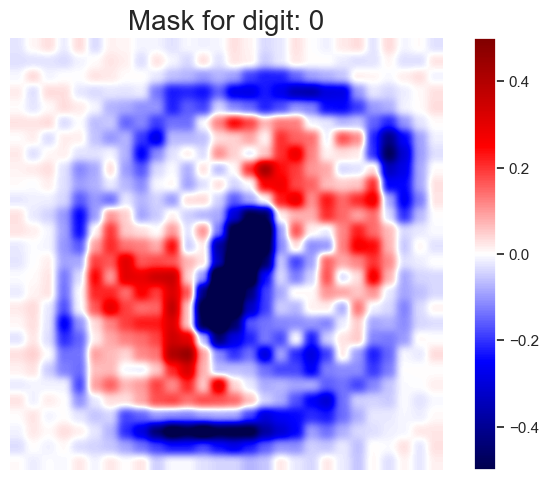

In [30]:
# Animate the weights
fps = 2
fig, ax = plt.subplots()
fig.subplots_adjust(left=0, bottom=0.02, right=1, top=1 - 0.08, wspace=None, hspace=None)

im = ax.imshow(weights(model, 0),
               cmap=mpl.colormaps['seismic'], norm=norm, interpolation='kaiser')
# ax.set_title("First layer weights")
# ax.set_axis('off')
ax.set_axis_off()
fig.colorbar(im, ax=ax)


def next_ani(i):
  ax.set_title(f"Mask for digit: {i}", fontsize=20)
  w = weights(model, i)
  im.set_array(w)
  return im,


anim = ani.FuncAnimation(fig, next_ani, frames=10, interval=1000)
anim.save('../resources/figures/digit_weights_mse.gif')